<a href="https://colab.research.google.com/github/asifajunaidahmad/GAN-ZeldaGameLevels/blob/main/WGANgp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
data_path ='/content/drive/MyDrive/playable'

In [16]:
!pip install wandb torchsummary easydict

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 144 kB 72.0 MB/s 
     |████████████████████████████████| 180 kB 66.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0fbc426f2f6d9d050a9b0be734765911706bb50eb089a15ed25754d5433ae26b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [18]:
import os
import time
import random
import wandb
import numpy as np
import torch
import torch.nn as nn
import errno
import torchvision
import torch.optim as optim

from mpl_toolkits.axes_grid1 import ImageGrid
from torchsummary import summary
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [20]:
__C = edict()

cfg = __C


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Run on device: {device}")
__C.PROJECT_NAME = "WGANGP"
__C.PROJECT_VERSION_NAME = "Standard WGANGP"
# Global
__C.NUM_EPOCHS = 10
__C.LEARNING_RATE = 1e-4
__C.BATCH_SIZE = 64
__C.DATASET_SIZE = None

__C.CRITIC_ITERATIONS = 5
__C.LAMBDA_GP = 10
# CHANNELS
__C.IMG_SIZE = 64
__C.CHANNELS_IMG = 3
__C.Z_DIMENSION = 128
# Models
__C.FEATURES_DISC = 64
__C.FEATURES_GEN = 64
# Paths and saves
__C.SAVE_EACH_EPOCH = 5
__C.OUT_DIR = ''
__C.SAVE_CHECKPOINT_PATH = '/content/drive/MyDrive'

# Display results
__C.NUM_SAMPLES = 64    # size grid for display images
__C.FREQ = 20

Run on device: cpu


In [21]:
def set_seed(val):
    """
    Freezes random sequences
    :param val: ``int`` random value
    """
    random.seed(val)
    np.random.seed(val)
    torch.manual_seed(val)
    torch.cuda.manual_seed(val)
    
set_seed(8989)

In [31]:
class GameLevelDataset(Dataset):
    def __init__(self, img_folder):
        """
        :param img_folder: path to dataset folder
        """
        self.img_folder = img_folder
        self.img_names = [n for n in os.listdir(img_folder) if n.endswith(('png', 'jpeg', 'jpg'))]

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_folder, self.img_names[idx])).convert('RGB')
        return self.transform(img)

    def __len__(self):
        return len(self.img_names)
    @property
    def transform(self):
        return transforms.Compose([transforms.Resize(cfg.IMG_SIZE),
                                   transforms.CenterCrop(cfg.IMG_SIZE),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                        std=[0.5, 0.5, 0.5])
                                   ])

In [32]:
dataset = GameLevelDataset(data_path)
dataloader = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True, pin_memory=True)

In [33]:
def show_batch(batch, num_samples=36, figsize=(10, 10), normalize=True):
    images = batch[:num_samples, ...]
    nrows = int(np.sqrt(num_samples))
    grid = torchvision.utils.make_grid(images, nrow=nrows, normalize=normalize, scale_each=True)
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.moveaxis(grid.detach().cpu().numpy(), 0, -1), aspect='auto')
    plt.axis('off')

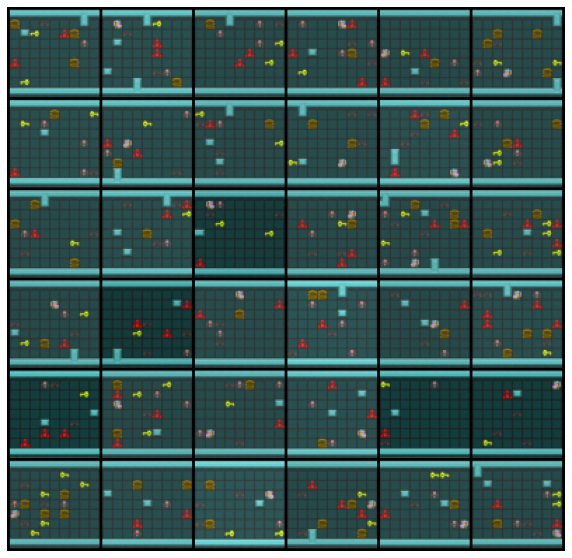

In [34]:
batch = next(iter(dataloader))
show_batch(batch)

In [35]:
def show_batch(batch, num_samples=36, figsize=(10, 10), normalize=True):
    images = batch[:num_samples, ...]
    nrows = int(np.sqrt(num_samples))
    grid = torchvision.utils.make_grid(images, nrow=nrows, normalize=normalize, scale_each=True)
    fig = plt.figure(figsize=figsize)
    plt.imshow(np.moveaxis(grid.detach().cpu().numpy(), 0, -1), aspect='auto')
    plt.axis('off')

In [36]:
class Generator(nn.Module):
    """Full convolution generator"""
    def __init__(self, channels_noise, channels_img, features_gen):
        """
        :param channels_noise: ``int``, input latent space dimension
        :param channels_img: ``int``,  3 for RGB image or 1 for GrayScale
        :param features_gen: ``int``, num features of generator
        """
        super().__init__()
        self.body = nn.Sequential(
            Generator._default_block(channels_noise, features_gen * 8, 4, 1, 0),    # 4x4
            Generator._default_block(features_gen * 8, features_gen * 4, 4, 2, 1),  # 8x8
            Generator._default_block(features_gen * 4, features_gen * 2, 4, 2, 1),   # 16x16
            Generator._default_block(features_gen * 2, features_gen, 4, 2, 1),   # 32x32
            nn.ConvTranspose2d(
                features_gen, channels_img, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out dimension: [N x 3 x 64 x 64] with range [-1, 1]
        )

    @staticmethod
    def _default_block(in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.body(x)
    

In [37]:
class Critic(nn.Module):
    """Standard full convolution discriminator"""
    def __init__(self, in_channels, features_d):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_channels, features_d, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            Critic._default_block(features_d, features_d * 2, 4, 2, 1),
            Critic._default_block(features_d * 2, features_d * 4, 4, 2, 1),
            Critic._default_block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)
        )

    @staticmethod
    def _default_block(in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.body(x)

In [38]:
def init_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [41]:
class MetricLogger:
    """Metric class"""
    def __init__(self, project_version_name, wab=True, show_accuracy=True, resume_id=False):
        """
        :param project_version_name: name of current version of project
        :param wab: good realtime metric, you can register free account in https://wandb.ai/
        :param show_accuracy: if True: show accuracy on real and fake data
        """
        self.project_version_name = project_version_name
        self.show_acc = show_accuracy
        self.data_subdir = f"{os.path.join(cfg.OUT_DIR, self.project_version_name)}/imgdata"
        
        self.g_loss = []
        self.d_loss = []

        if wab:
            if resume_id:
                wandb_id = resume_id
            else:
                wandb_id = wandb.util.generate_id()
            wandb.init(id=wandb_id, project='WGANGP', name=project_version_name, resume=True)
            wandb.config.update({
                'train_images_count': cfg.DATASET_SIZE,
                'init_lr': cfg.LEARNING_RATE,
                'noise_z_size': cfg.Z_DIMENSION,
                'batch_size': cfg.BATCH_SIZE,
                'critic_iterations': cfg.CRITIC_ITERATIONS,
                'lambda_gp': cfg.LAMBDA_GP,
                'initialization_weights': 'None',
                'beta 1': 0.0,
                'beta 2': 0.9
            })

    def display_status(self, epoch, num_epochs, batch_idx, num_batches, dis_loss,
                       gen_loss, acc_real=None, acc_fake=None):
        """
        Display training progress
        :param epoch: ``int``, current epoch
        :param num_epochs: ``int``, numbers epoch
        :param batch_idx: ``int``, current batch
        :param num_batches: ``int``, numbers bathes
        :param dis_loss: ``torch.autograd.Variable``, discriminator loss
        :param gen_loss: ``torch.autograd.Variable``, generator loss
        :param acc_real: ``torch.autograd.Variable``, discriminator predicted on real data
        :param acc_fake: ``torch.autograd.Variable``, discriminator predicted on fake data
        """
        if isinstance(dis_loss, torch.autograd.Variable):
            dis_loss = dis_loss.item()
        if isinstance(gen_loss, torch.autograd.Variable):
            gen_loss = gen_loss.item()
        if self.show_acc and isinstance(acc_real, torch.autograd.Variable):
            acc_real = acc_real.float().mean().item()
        if self.show_acc and isinstance(acc_fake, torch.autograd.Variable):
            acc_fake = acc_fake.float().mean().item()

        print('Batch Num: [{}/{}], Epoch: [{}/{}]'.format(batch_idx, num_batches, epoch, num_epochs))
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(dis_loss, gen_loss))
        if acc_real and acc_fake:
            print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(acc_real, acc_fake))

    def log(self, dis_loss, gen_loss, acc_real=None, acc_fake=None):
        """
        Logging values
        :param dis_loss: ``torch.autograd.Variable``, critical loss
        :param gen_loss: ``torch.autograd.Variable``, generator loss
        :param acc_real: ``torch.autograd.Variable``, D(x) predicted on real data
        :param acc_fake: ``torch.autograd.Variable``, D(G(z)) paramredicted on fake data
        """
        if isinstance(dis_loss, torch.autograd.Variable):
            dis_loss = dis_loss.item()
        if isinstance(gen_loss, torch.autograd.Variable):
            gen_loss = gen_loss.item()
        if self.show_acc and isinstance(acc_real, torch.autograd.Variable):
            acc_real = acc_real.float().mean().item()
        if self.show_acc and isinstance(acc_fake, torch.autograd.Variable):
            acc_fake = acc_fake.float().mean().item()

        wandb.log({'d_loss': dis_loss, 'g_loss': gen_loss, 'D(x)': acc_real, 'D(G(z))': acc_fake})
        self.g_loss.append(gen_loss)
        self.d_loss.append(dis_loss)

    def log_image(self, images, num_samples, epoch, batch_idx, num_batches, normalize=True):
        """
        Create image grid and save it
        :param images: ``Tor    ch.Tensor(N,C,H,W)``, tensor of images
        :param num_samples: ``int``, number of samples
        :param normalize: if True normalize images
        :param epoch: ``int``, current epoch
        :param batch_idx: ``int``, current batch
        :param num_batches: ``int``, numbers bathes
        """
        images = images[:num_samples, ...]
        nrows = int(np.sqrt(num_samples))
        grid = torchvision.utils.make_grid(images, nrow=nrows, normalize=normalize, scale_each=True)
        self.save_torch_images(grid, epoch, batch_idx, num_batches)
        wandb.log({'fixed_noise': [wandb.Image(np.moveaxis(grid.detach().cpu().numpy(), 0, -1))]})

    def save_torch_images(self, grid, epoch, batch_idx, num_batches):
        """
        Display and save image grid
        :param grid: ``ndarray``, grid image
        :param epoch: ``int``, current epoch
        :param batch_idx: ``int``, current batch
        :param num_batches: ``int``, numbers bathes
        """
        out_dir = self.data_subdir
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(grid.detach().cpu().numpy(), 0, -1), aspect='auto')
        plt.axis('off')
        MetricLogger._save_images(fig, out_dir, epoch, batch_idx, num_batches)
        plt.close()

    @staticmethod
    def _save_images(fig, out_dir, epoch, batch_idx, num_batches):
        """
        Saves image on drive
        :param fig: pls.figure object
        :param out_dir: path to output dir
        :param epoch: ``int``, current epoch
        :param batch_idx: ``int``, current batch
        :param num_batches: ``int``, numbers bathes
        """
        MetricLogger._make_dir(out_dir)
        image_name = f"epoch({str(epoch).zfill(len(str(cfg.NUM_EPOCHS)))})-" \
                     f"batch({str(batch_idx).zfill(len(str(num_batches)))}).jpg"
        fig.savefig('{}/{}'.format(out_dir, image_name))

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [42]:
def get_random_noise(size, dim, device):
    """
     Get random noise from normal distribution
    :param size: ``int``, number of samples (batch)
    :param dim: ``int``, dimension
    :param device: cuda or cpu device
    :return: Tensor([size, dim, 1, 1])
    """
    return torch.randn(size, dim, 1, 1).to(device)


def checkpoint(epoch, end_epoch, gen, critic, opt_gen, opt_critic, fixed_noise):
    print("=> Saving checkpoint")
    torch.save({
        'gen': gen.state_dict(),
        'critic': critic.state_dict(),
        'opt_gen': opt_gen.state_dict(),
        'opt_critic': opt_critic.state_dict(),
        'start_epoch': epoch,
        'end_epoch': end_epoch,
        'fixed_noise': fixed_noise
    }, f"{cfg.SAVE_CHECKPOINT_PATH}/WGAN_GP_epoch_{epoch}.pth.tar")
    print(f"=> Checkpoint save to {cfg.SAVE_CHECKPOINT_PATH}")


def load_checkpoint(checkpoint, gen, critic, opt_gen, opt_critic):
    print("=> Load checkpoint...")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['critic'])
    opt_gen.load_state_dict(checkpoint['opt_gen'])
    opt_disc.load_state_dict(checkpoint['opt_critic'])
    print("=> Checkpoint loaded")
    return checkpoint['start_epoch'], checkpoint['end_epoch'], checkpoint['fixed_noise']


def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [55]:
def epoch_time(f):
    """Calculate time of each epoch"""
    def timed(*args, **kwargs):
        ts = time.time()
        result = f(*args, **kwargs)
        te = time.time()
        print("epoch time: %2.1f min" % ((te-ts)/60))
        return result
    return timed


@epoch_time
def train_one_epoch(epoch, dataloader, gen, critic, opt_gen, opt_critic,
                    fixed_noise, device, metric_logger, num_samples, freq=100):
    """
    Train one epoch
    :param epoch: ``int`` current epoch
    :param dataloader: object of dataloader
    :param gen: Generator model
    :param disc: Discriminator model
    :param criterion: Loss function (for this case: binary cross entropy)
    :param opt_gen: Optimizer for generator
    :param opt_disc: Optimizer for discriminator
    :param fixed_noise: ``tensor[[cfg.BATCH_SIZE, latent_space_dimension, 1, 1]]`` fixed noise (latent space) for image metrics
    :param device: cuda device or cpu
    :param metric_logger: object of MetricLogger
    :param num_samples: ``int`` well retrievable sqrt() (for example: 4, 16, 64) for good result,
    number of samples for grid image metric
    :param freq: ``int``, freq < len(dataloader)`` freq for display results
    """
    for batch_idx, img in enumerate(dataloader):
        real = img.to(device)
        # Train critic
        acc_real = 0
        acc_fake = 0
        for _ in range(cfg.CRITIC_ITERATIONS):
            noise = get_random_noise(cfg.BATCH_SIZE, cfg.Z_DIMENSION, device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            acc_real += critic_real
            critic_fake = critic(fake).reshape(-1)
            acc_fake += critic_fake
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = -1 * (torch.mean(critic_real) - torch.mean(critic_fake)) + cfg.LAMBDA_GP * gp
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()
                
        acc_real = acc_real / cfg.CRITIC_ITERATIONS
        acc_fake = acc_fake / cfg.CRITIC_ITERATIONS
        
        # Train generator: minimize -E[critic(gen_fake)]
        output = critic(fake).reshape(-1)
        loss_gen = -1 * torch.mean(output)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        # logs metrics
        if batch_idx % freq == 0:
            with torch.no_grad():
                metric_logger.log(loss_critic, loss_gen, acc_real, acc_fake)
                fake = gen(fixed_noise)
                metric_logger.log_image(fake, num_samples, epoch, batch_idx, len(dataloader))
                metric_logger.display_status(epoch, cfg.NUM_EPOCHS, batch_idx, len(dataloader), loss_critic, loss_gen, acc_real, acc_fake)

In [56]:
# defininig models
gen = Generator(cfg.Z_DIMENSION, cfg.CHANNELS_IMG, cfg.FEATURES_GEN).to(device)
critic = Critic(cfg.CHANNELS_IMG, cfg.FEATURES_DISC).to(device)
# init weights
# init_weights(gen)
# init_weights(critic)
# defining optimizers
opt_gen = optim.Adam(gen.parameters(), lr=cfg.LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=cfg.LEARNING_RATE, betas=(0.0, 0.9))

In [57]:
start_epoch = 1
end_epoch = cfg.NUM_EPOCHS
fixed_noise = get_random_noise(cfg.BATCH_SIZE, cfg.Z_DIMENSION, device)

In [58]:
gen.train()
critic.train()
metric_logger = MetricLogger(cfg.PROJECT_VERSION_NAME)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: ERROR API key must be 40 characters long, yours was 6


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [59]:
start_time = time.time()
for epoch in range(start_epoch, end_epoch + 1):
    train_one_epoch(epoch, dataloader, gen, critic, opt_gen, opt_critic,
                    fixed_noise, device, metric_logger, num_samples=cfg.NUM_SAMPLES, freq=cfg.FREQ)
    if epoch == cfg.NUM_EPOCHS + 1:
        checkpoint(epoch, end_epoch, gen, critic, opt_gen, opt_critic, fixed_noise)
    elif epoch % cfg.SAVE_EACH_EPOCH == 0:
        checkpoint(epoch, end_epoch, gen, critic, opt_gen, opt_critic, fixed_noise)

total_time = time.time() - start_time
print(f"=> Training time:{total_time}")

Batch Num: [0/7], Epoch: [1/10]
Discriminator Loss: -3.3272, Generator Loss: 2.0449
D(x): 2.0604, D(G(z)): -0.6093
epoch time: 0.7 min
Batch Num: [0/7], Epoch: [2/10]
Discriminator Loss: -49.8266, Generator Loss: 24.7390
D(x): 30.2360, D(G(z)): -21.9597
epoch time: 0.6 min
Batch Num: [0/7], Epoch: [3/10]
Discriminator Loss: -73.9541, Generator Loss: 42.6668
D(x): 43.1692, D(G(z)): -38.0101
epoch time: 0.6 min
Batch Num: [0/7], Epoch: [4/10]
Discriminator Loss: -59.3611, Generator Loss: 28.8764
D(x): 41.1532, D(G(z)): -36.7640
epoch time: 0.6 min
Batch Num: [0/7], Epoch: [5/10]
Discriminator Loss: -40.1483, Generator Loss: 30.8841
D(x): 31.2578, D(G(z)): -23.0232
epoch time: 0.6 min
=> Saving checkpoint
=> Checkpoint save to /content/drive/MyDrive
Batch Num: [0/7], Epoch: [6/10]
Discriminator Loss: -32.4862, Generator Loss: 20.4056
D(x): 23.2099, D(G(z)): -19.5363
epoch time: 0.6 min
Batch Num: [0/7], Epoch: [7/10]
Discriminator Loss: -26.1263, Generator Loss: 20.6041
D(x): 19.6781, D(G

In [60]:
def get_interpolations(noise1, noise2, num_interpolates):
    x = [((1.0 - (i/num_interpolates)) * noise1) + ((i/num_interpolates) * noise2) for i in range(num_interpolates + 1)]
    return torch.cat(x, dim = 0)

In [61]:
def visualize_batch(images_list, size = 14, shape = (6, 6), title = None, save = None, return_images = False):
    images_list = (images_list - images_list.min())/(images_list.max() - images_list.min())

    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.04)
    for ax, image in zip(grid, images_list):
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()
    
    if return_images:
        return images_list


Showing Generated Samples



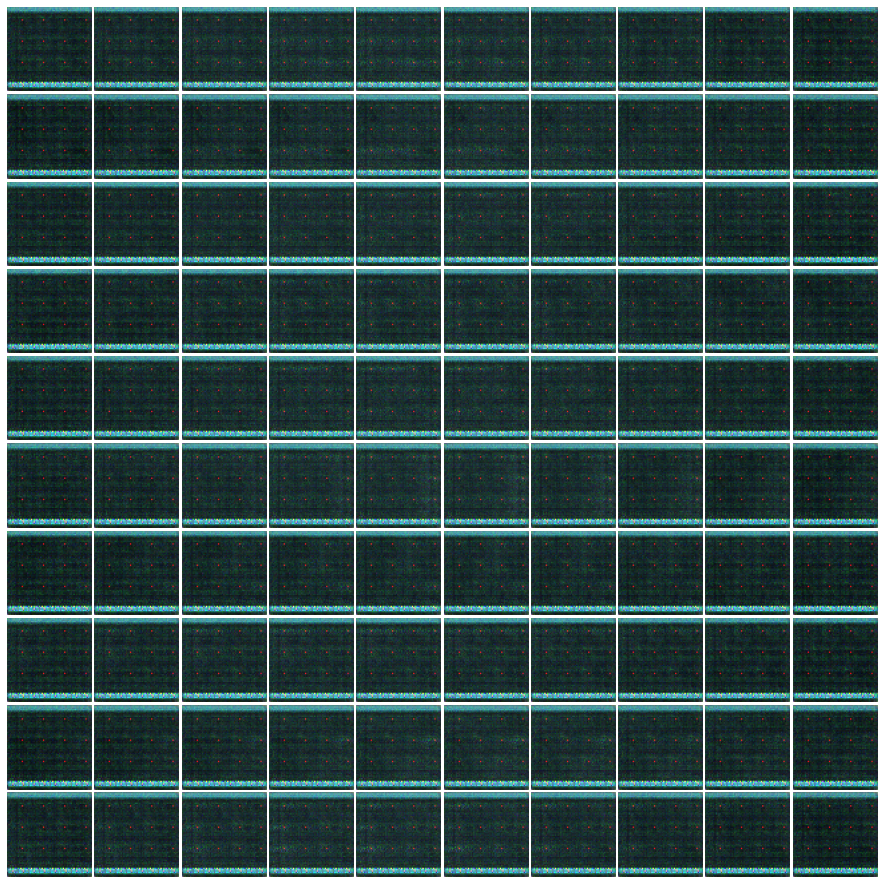

In [62]:
with torch.no_grad():
    interpolations = []
    for _ in range(10):
        noise1 = get_random_noise(1, cfg.Z_DIMENSION, device)
        noise2 = get_random_noise(1, cfg.Z_DIMENSION, device)
        interpolations.append(get_interpolations(noise1, noise2, 9).to(device))
    
    interpolations = torch.cat(interpolations, dim = 0)
    false_images = gen(interpolations).cpu()
    print(f'\nShowing Generated Samples\n')
    visualize_batch(false_images, shape = (10, 10), size = 16, save = None)

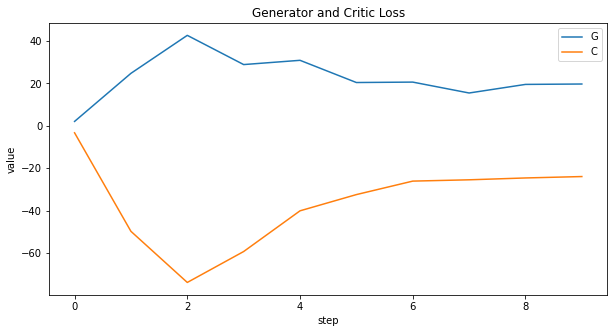

In [63]:
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss")
plt.plot(metric_logger.g_loss,label="G")
plt.plot(metric_logger.d_loss,label="C")
plt.xlabel("step")
plt.ylabel("value")
plt.legend()
plt.show()